# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
sns.set(style='whitegrid')

from hw2code import find_best_split, DecisionTree

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [2]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0, )
]

In [3]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

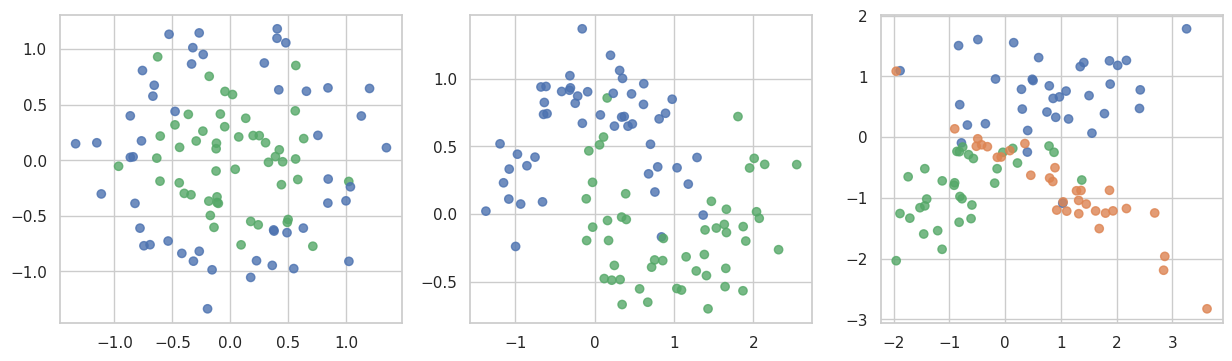

In [4]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [5]:
def plot_surface(clf, X, y, accuracy_score=None, title=None):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)
    
    if title:
        plt.title(title)
    if accuracy_score:
        plt.scatter([], [], alpha=0, label=f'Accuracy: {accuracy_score:.4f}')
        plt.legend()

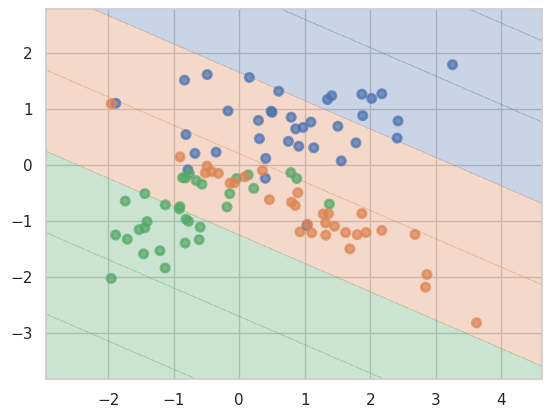

In [6]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

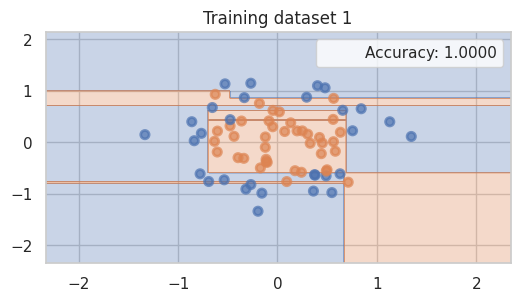

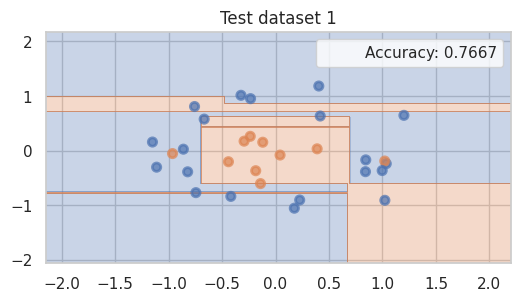

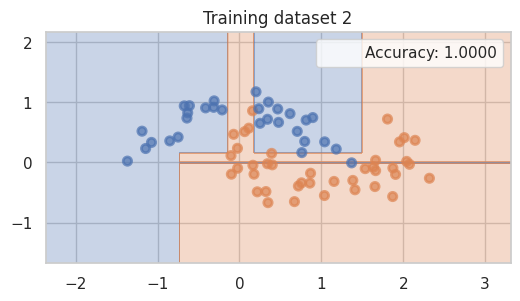

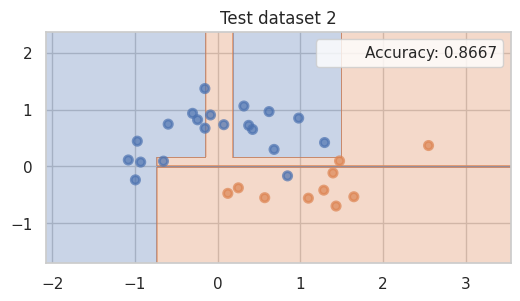

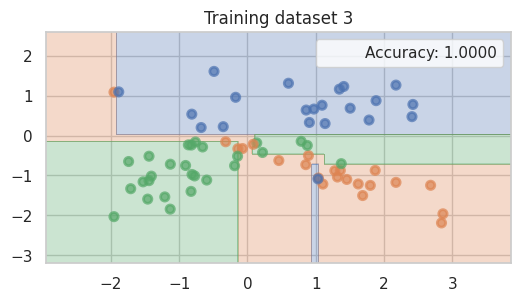

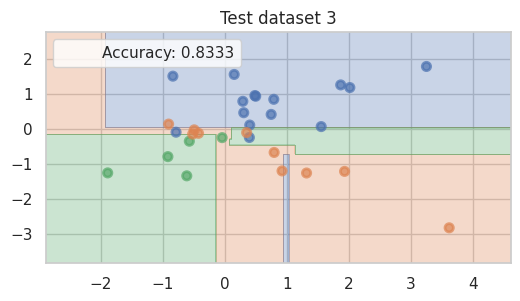

<Figure size 640x480 with 0 Axes>

In [7]:
for i, (X, y) in enumerate(datasets):
    X, y = datasets[i]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    classification = DecisionTreeClassifier().fit(X_train, y_train)

    y_train_pred = classification.predict(X_train)
    y_test_pred = classification.predict(X_test)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    plt.figure(figsize=(6, 3))
    plot_surface(classification, X_train, y_train, accuracy_score=train_accuracy, title=f'Training dataset {i+1}')
    plt.show()

    plt.figure(figsize=(6, 3))
    plot_surface(classification, X_test, y_test, accuracy_score=test_accuracy, title=f'Test dataset {i+1}')
    plt.show()

plt.tight_layout()
plt.show()

__Ответ:__ На графиках видны тонкие полоски и сильно изломанные линии, соответствующие листам дерева. Это говоорит о переобучении

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

=== Dataset 1 ===
max_depth=2, min_samples_leaf=5 | Train acc: 0.814 | Test acc: 0.667
max_depth=4, min_samples_leaf=3 | Train acc: 0.943 | Test acc: 0.733
max_depth=None, min_samples_leaf=1 | Train acc: 1.000 | Test acc: 0.733


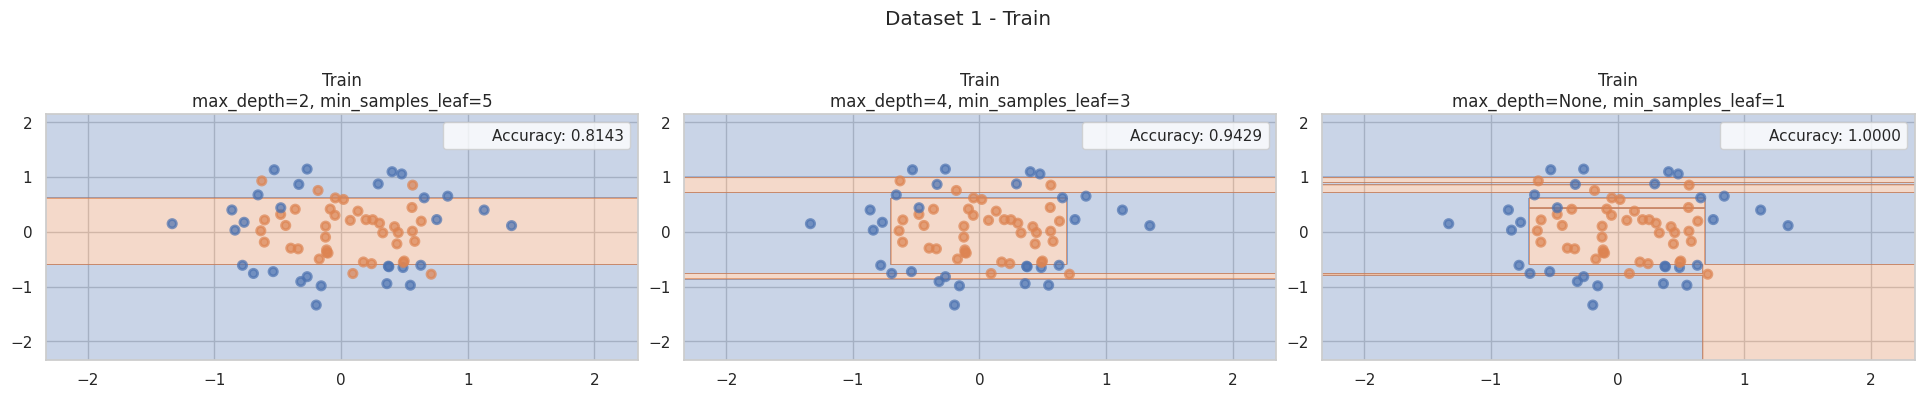

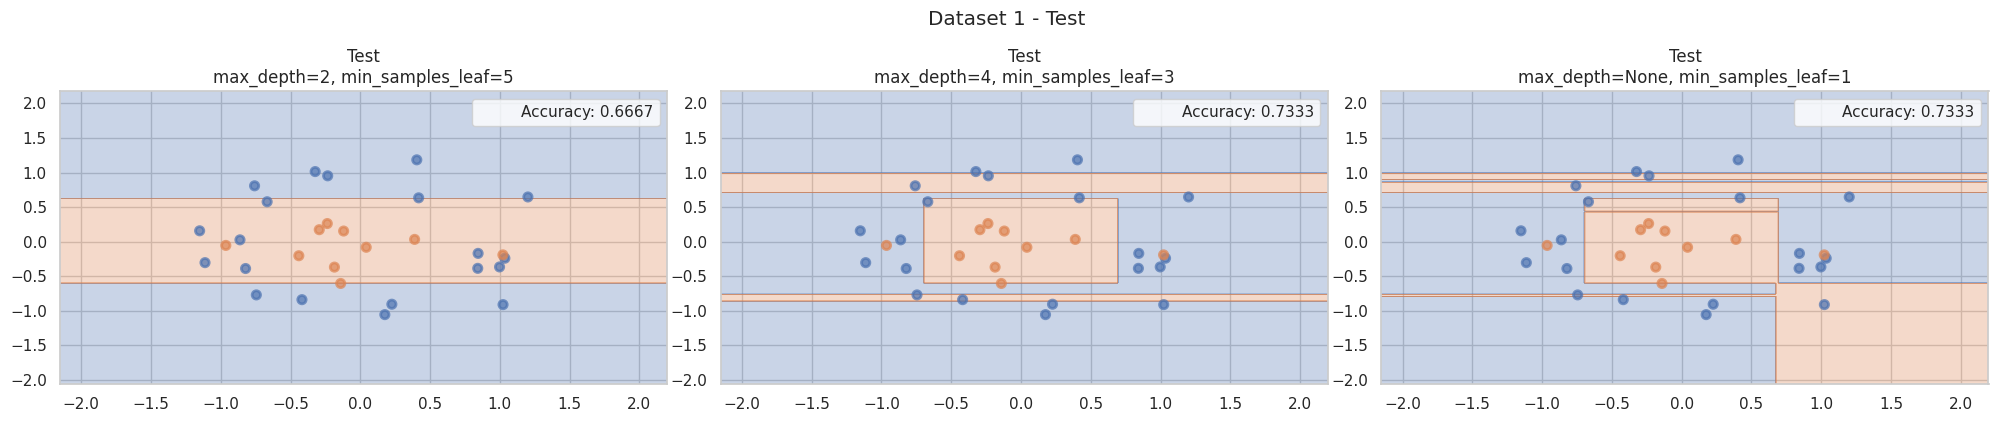

=== Dataset 2 ===
max_depth=2, min_samples_leaf=5 | Train acc: 0.886 | Test acc: 0.800
max_depth=4, min_samples_leaf=3 | Train acc: 0.986 | Test acc: 0.767
max_depth=None, min_samples_leaf=1 | Train acc: 1.000 | Test acc: 0.867


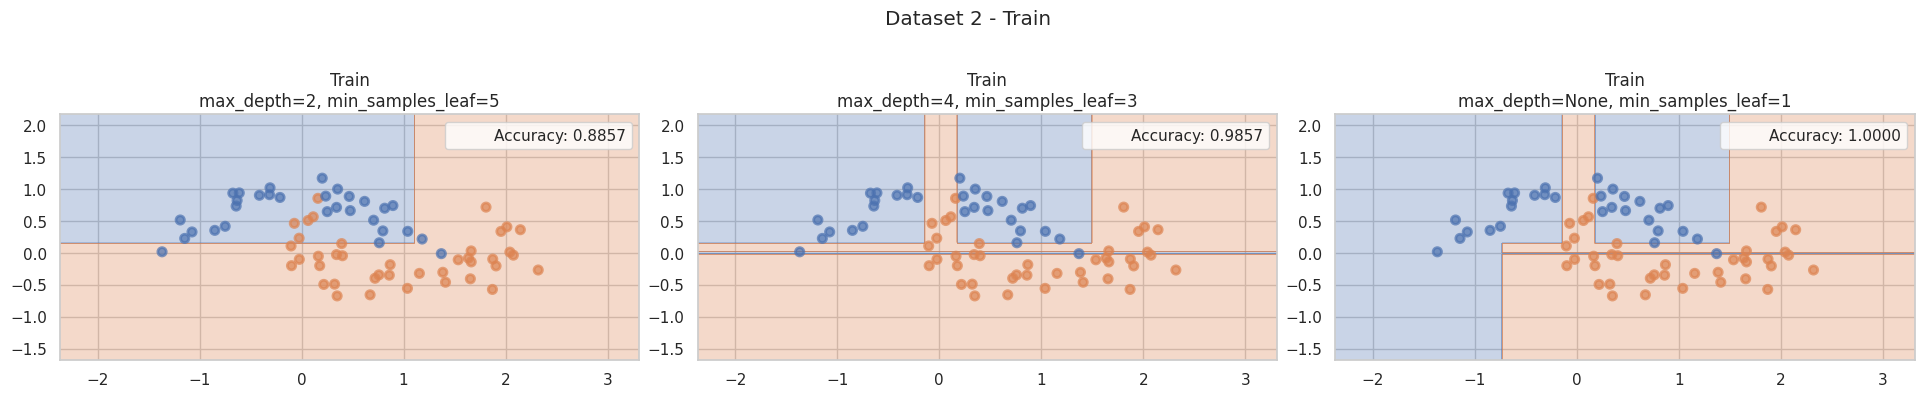

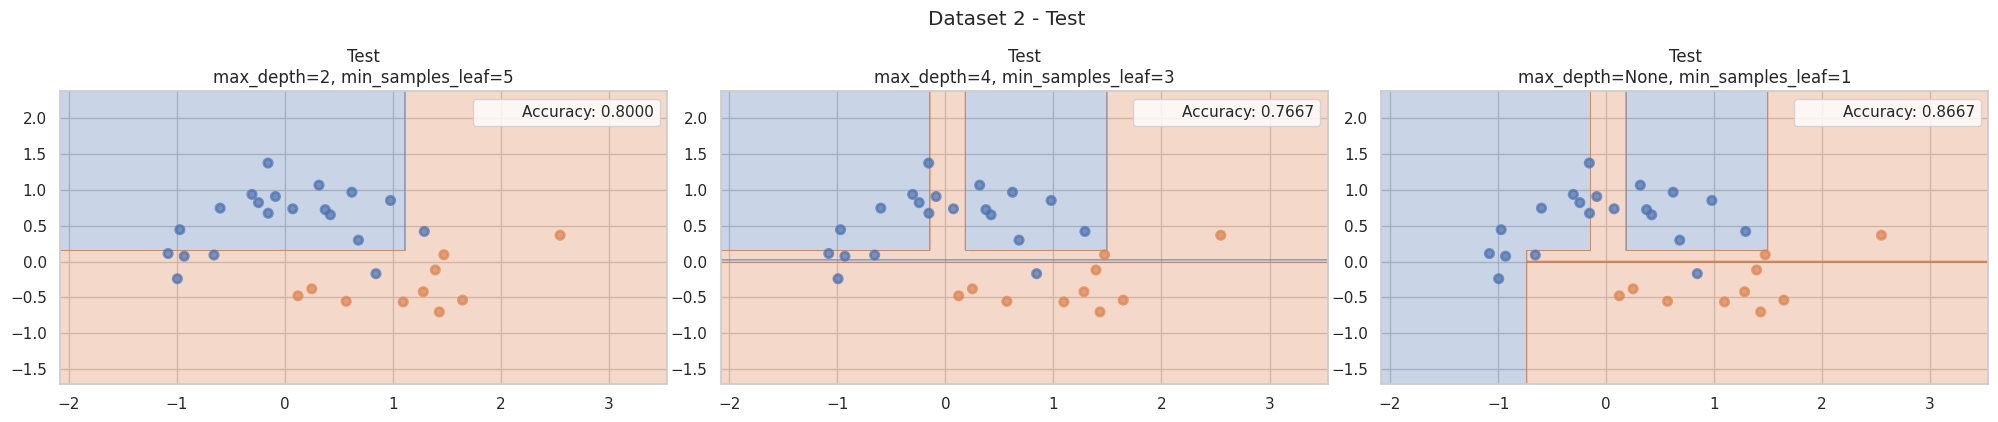

=== Dataset 3 ===
max_depth=2, min_samples_leaf=5 | Train acc: 0.886 | Test acc: 0.767
max_depth=4, min_samples_leaf=3 | Train acc: 0.914 | Test acc: 0.767
max_depth=None, min_samples_leaf=1 | Train acc: 1.000 | Test acc: 0.833


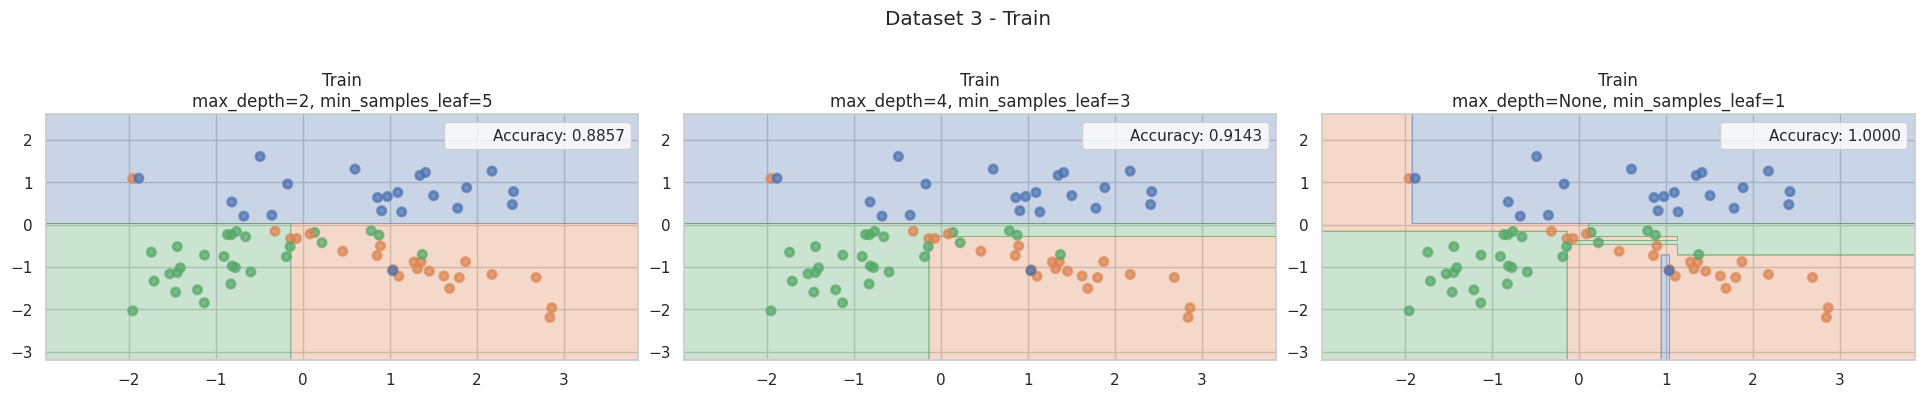

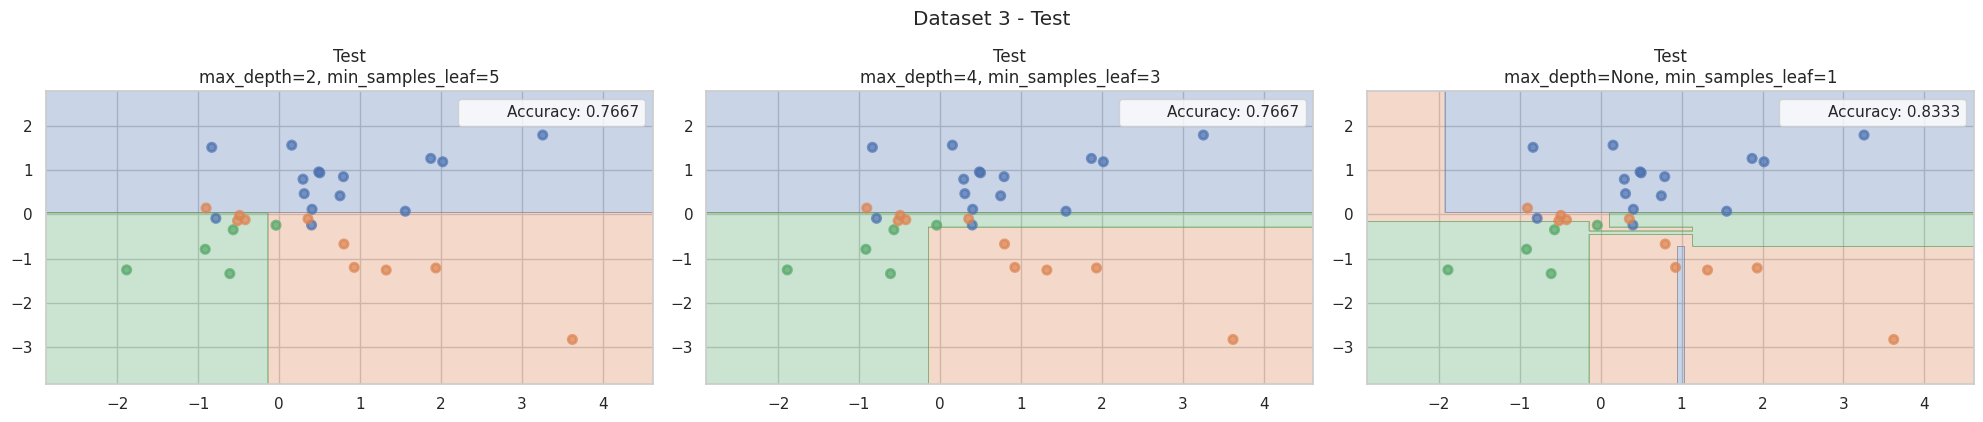

In [ ]:
from itertools import product

params = {
    'max_depth': [2, 4, None],
    'min_samples_leaf': [5, 3, 1]
}
param_combinations = list(product(params['max_depth'], params['min_samples_leaf']))

for idx, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    fig_train, axes_train = plt.subplots(1, 3, figsize=(20, 4))
    fig_test, axes_test = plt.subplots(1, 3, figsize=(20, 4))
    for i, (max_depth, min_samples_leaf) in enumerate(param_combinations[0::+4]):
        clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
        clf.fit(X_train, y_train)
        train_acc = accuracy_score(y_train, clf.predict(X_train))
        test_acc = accuracy_score(y_test, clf.predict(X_test))
        plt.sca(axes_train[i])
        plot_surface(clf, X_train, y_train, accuracy_score=train_acc,
                     title=f"Train\nmax_depth={max_depth}, min_samples_leaf={min_samples_leaf}")
        plt.sca(axes_test[i])
        plot_surface(clf, X_test, y_test, accuracy_score=test_acc,
                     title=f"Test\nmax_depth={max_depth}, min_samples_leaf={min_samples_leaf}")
        print("__________________________")
    plt.tight_layout()
    fig_train.suptitle(f"Dataset {idx+1} - Train", y=1.05)
    fig_test.suptitle(f"Dataset {idx+1} - Test", y=1.05)
    plt.show()

__Ответ:__ На графиках заметно, что учеличение глубины дерева делает разделяющую поверхность более изломанной, что повышает риск переобучения

Интересно, что на втором датасете дерево с глубиной 2 показывает лучший результат на тестовой выборке, чем дерево с глубиной 4. Во всех остальных случаях увеличение сложности модели положительно влияет на точность результатов на тестовой выборке.

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

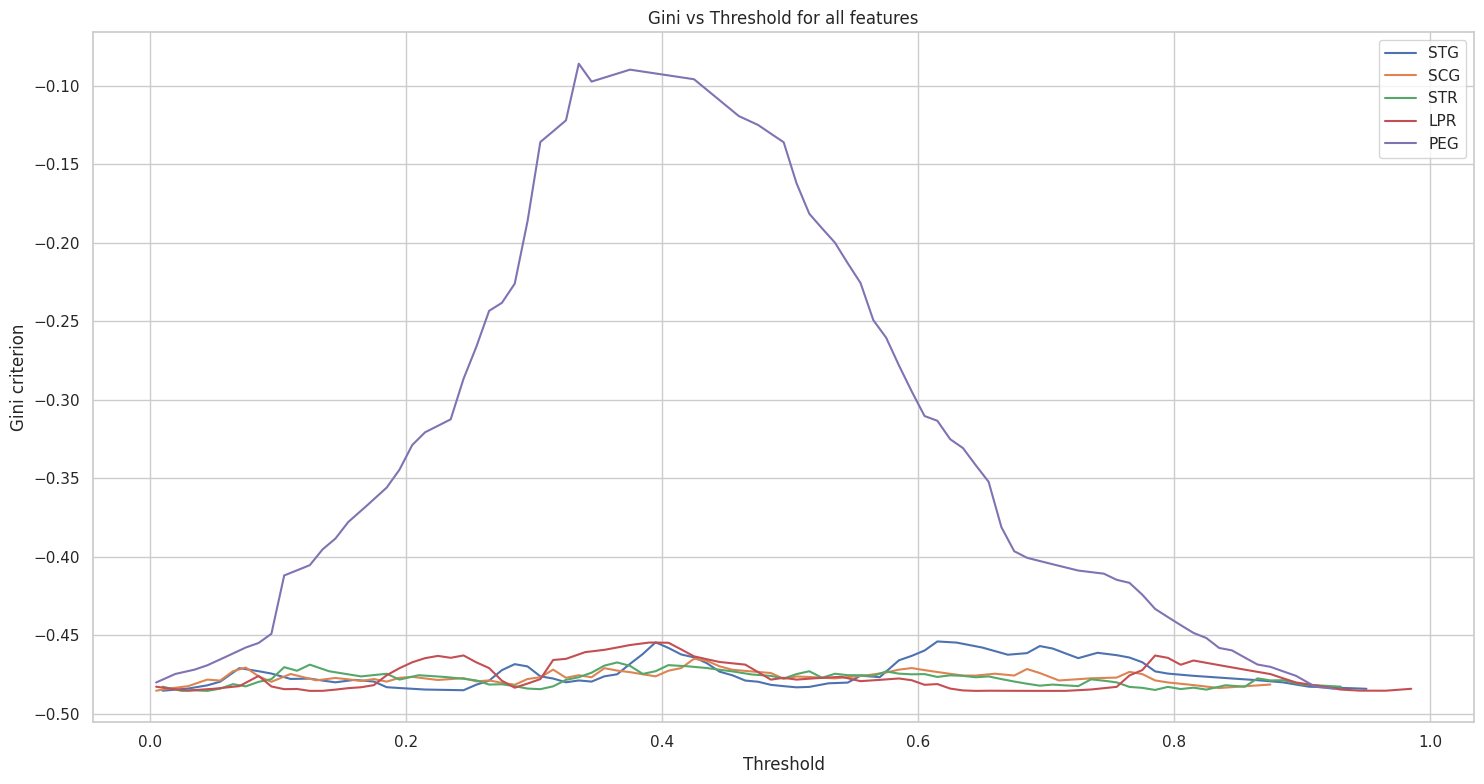

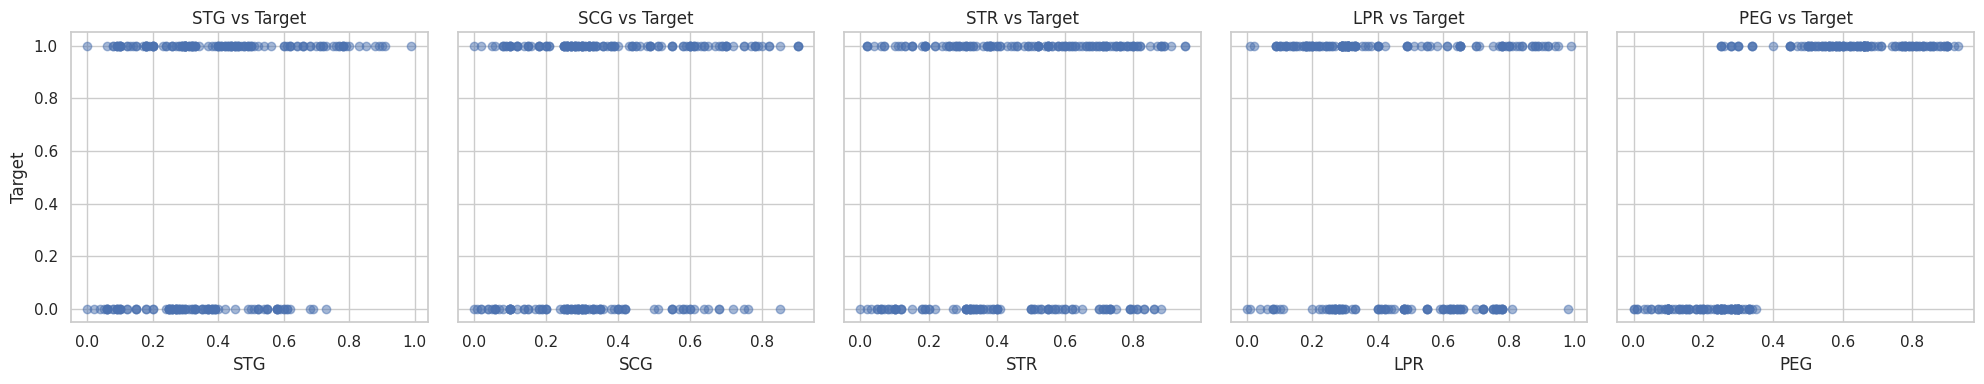

In [9]:
df = pd.read_csv("datasets/students.csv")
X = df.iloc[:, :5]
y = df.iloc[:, -1]

plt.figure(figsize=(15, 8))
for i, col in enumerate(X.columns):
    thresholds, ginis, _, _ = find_best_split(X[col], y)
    plt.plot(thresholds, ginis, label=f"{col}")

plt.xlabel("Threshold")
plt.ylabel("Gini criterion")
plt.title("Gini vs Threshold for all features")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)
for i, col in enumerate(X.columns):
    axes[i].scatter(X[col], y, alpha=0.5)
    axes[i].set_xlabel(col)
    axes[i].set_title(f"{col} vs Target")
    axes[i].grid(True)
axes[0].set_ylabel("Target")
plt.tight_layout()
plt.show()

__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:**
Лучший признак по критерию Джини - это PEG, так как кривая имеет наименьшее по модулю значение критерия Джини.

На Scatter-графиках видно, что только признак PEG имеет четкое разделение на классы без большого пересечения.

Кривая для хорошего признака имеет ярко выраженный минимум и большую амплитуду между пиком и минимумом.

Плохие признаки не обладают такими свойствами, деление по таким признакам почти не влияет на чистоту подвыборок.

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [10]:
import sklearn as sk
from sklearn.preprocessing import LabelEncoder
import hw2code
from hw2code import DecisionTree

df = pd.read_csv('datasets/agaricus-lepiota.data', header=None)

encoder = sk.preprocessing.LabelEncoder()
for col in df.columns:
  df[col] = encoder.fit_transform(df[col])

X = df.drop(columns=0).values
y = df[0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=42)


tree = DecisionTree(['categorical'] * X.shape[1])
tree.fit(X_train, y_train)
y_pred_train = tree.predict(X_train)
y_pred_test = tree.predict(X_test)
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print("Train accuracy:", train_accuracy)
print("Test accuracy:", test_accuracy)
print("Tree depth:", tree._depth)


Train accuracy: 1.0
Test accuracy: 1.0
Tree depth: 7


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

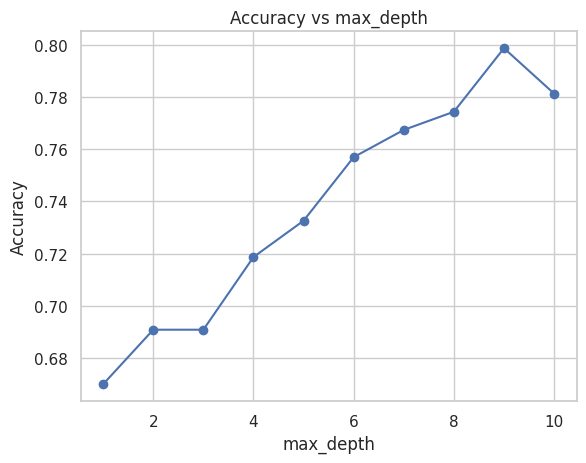

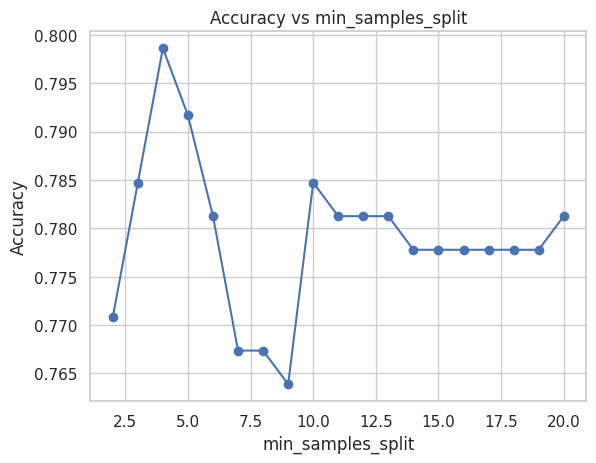

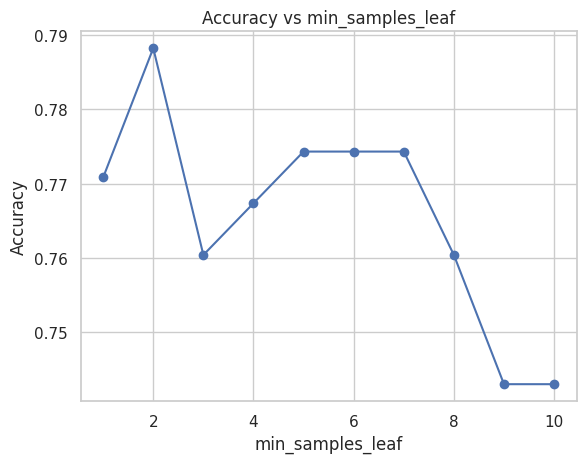

In [ ]:
df = pd.read_csv('datasets/tic-tac-toe-endgame.csv')

X, y = df.drop('V10', axis=1).values, (df['V10'] == 'positive').astype(int).values

feature_types = ['categorical'] * X.shape[1]

def parameters_vs_accuracy_plot(name, values):
    scores = []
    for val in values:
        kwargs = {name: val}
        classificator = DecisionTree(feature_types, **kwargs)
        classificator.fit(X_train, y_train)
        y_pred = classificator.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        scores.append(acc)
    plt.figure()
    plt.plot(values, scores, marker='o')
    plt.title(f"Accuracy and {name}")
    plt.xlabel(name)
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

parameters_vs_accuracy_plot('max_depth', list(range(1, 11)))
parameters_vs_accuracy_plot('min_samples_split', list(range(2, 21)))
parameters_vs_accuracy_plot('min_samples_leaf', list(range(1, 11)))

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score

class DecisionTreeReal:
    def fit(self, X, y):
        self.model = DecisionTree(['real'] * X.shape[1])
        self.model.fit(X.values.astype(float) if hasattr(X, 'values') else X, y.values if hasattr(y, 'values') else y)
        return self

    def predict(self, X):
        return self.model.predict(X.values.astype(float) if hasattr(X, 'values') else X)

    def get_params(self, deep=True):
        return {}

class DecisionTreeCategorical:
    def fit(self, X, y):
        self.model = DecisionTree(['categorical'] * X.shape[1])
        self.model.fit(X.values if hasattr(X, 'values') else X, y.values if hasattr(y, 'values') else y)
        return self

    def predict(self, X):
        return self.model.predict(X.values if hasattr(X, 'values') else X)

    def get_params(self, deep=True):
        return {}

class DecisionTreeOneHot:
    def __init__(self):
        self.encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    def fit(self, X, y):
        X_data = X.values if hasattr(X, 'values') else X
        self.encoder.fit(X_data)
        X_encoded = self.encoder.transform(X_data)
        self.model = DecisionTree(['real'] * X_encoded.shape[1])
        self.model.fit(X_encoded, y.values if hasattr(y, 'values') else y)
        return self

    def predict(self, X):
        X_data = X.values if hasattr(X, 'values') else X
        return self.model.predict(self.encoder.transform(X_data))

    def get_params(self, deep=True):
        return {}

mushrooms = pd.read_csv('datasets/agaricus-lepiota.data', header=None)
tic_tac_toe = pd.read_csv('datasets/tic-tac-toe-endgame.csv')
cars = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', header=None)
nursery = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data', header=None)

targets = {'mushrooms': 0, 'tic_tac_toe': tic_tac_toe.columns[-1], 'cars': cars.columns[-1], 'nursery': nursery.columns[-1]}
target_replacer = {
    'mushrooms': {0: {'p': 0, 'e': 1}},
    'tic_tac_toe': {targets['tic_tac_toe']: {'negative': 0, 'positive': 1}},
    'cars': {targets['cars']: {'unacc': 0, 'acc': 0, 'good': 1, 'vgood': 1}},
    'nursery': {targets['nursery']: {'not_recom': 0, 'recommend': 0, 'very_recom': 1, 'priority': 1, 'spec_prior': 1}}
}

for name, target in targets.items():
    df = locals()[name]
    if isinstance(target, int):
        df[0] = df[0].map(target_replacer[name][0])
    else:
        df[target] = df[target].map(target_replacer[name][target])

encoder = LabelEncoder()
datasets = {'mushrooms': mushrooms, 'tic_tac_toe': tic_tac_toe, 'cars': cars, 'nursery': nursery}

for name, df in datasets.items():
    features = [col for col in df.columns if col != targets[name]]
    for col in features:
        df[col] = encoder.fit_transform(df[col].astype(str))

models = [
    ('Real', DecisionTreeReal()),
    ('Categorical', DecisionTreeCategorical()),
    ('OneHot', DecisionTreeOneHot()),
    ('Classifier', DecisionTreeClassifier())
]

results = pd.DataFrame(columns=['Dataset'] + [m[0] for m in models])

for dataset_name, df in datasets.items():
    X = df.drop(columns=targets[dataset_name])
    y = df[targets[dataset_name]]
    row = {'Dataset': dataset_name}
    for model_name, model in models:
        try:
            accuracy = cross_val_score(model, X, y, cv=10, scoring='accuracy').mean()
            row[model_name] = accuracy
        except Exception as ex:
            row[model_name] = f'Error: {str(ex)}'
    results = pd.concat([results, pd.DataFrame([row])], ignore_index=True)

results.set_index('Dataset', inplace=True)
pd.options.display.float_format = '{:.4f}'.format
print('Comparison of Decision Tree Models:')
print(results)

    

Comparison of Decision Tree Models:
              Real  Categorical  OneHot  Classifier
Dataset                                            
mushrooms   1.0000       1.0000  1.0000      0.9611
tic_tac_toe 0.6730       0.7282  0.5446      0.7904
cars        0.8656       0.8656  0.9259      0.9433
nursery     0.9995       0.9995  0.9997      0.9997


__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**
Ранжирование алгоритмов зависит от выбранного датасета. Это связано с тем, что разные датасеты имеют разные типы признаков, разные классы, разные зависимости между признаками и целевой переменной.

Чтобы улучшить работу алгоритмов, можно эксперементировать с настройкой глубины дерева и размером узлов.

Вставьте что угодно, описывающее ваши впечатления от этого задания:

In [ ]:
я хочу питсы...